# ORIE 4580: Gender Bias in Corporate Settings

In [117]:
import enum
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, List
from dataclasses import dataclass, field
from enum import auto

In [136]:
RNG = np.random.default_rng()

In [119]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.family"] = "Times New Roman"

## §1. Implementing generic Markov chain simulations

In [120]:
class Model:

    def transition_rate(self, state):
        """Total transition rate out of the given state"""
        raise NotImplementedError

    def sample_next(self, state):
        """Generates a random state to come after the given state"""
        raise NotImplementedError

In [121]:
def run_dtmc(model: Model, state_init, n_steps=256):
    path = [state_init]
    for i in range(n_steps):
        path.append(model.sample_next(path[-1]))
    # Return a list of (time, state) pairs
    # This simulation is discrete-time, so time is an integer
    return list(enumerate(path))

#### CODE: `QueueModel` example

In [122]:
@dataclass
class QueueModel(Model):
    """Model of a queue

    The state is the number of customers currently in the queue.

    Parameters
    ----------
    rate_arrival: float
        Rate at which customers arrive at the queue.

    rate_service: float
        Rate at which customers leave the queue when it is nonempty.
    """

    rate_arrival: float
    rate_service: float

    def transition_rate(self, state: int):
        if state == 0:
            return self.rate_arrival
        else:
            return self.rate_arrival + self.rate_service

    def sample_next(self, state: int):
        if RNG.random() < self.rate_arrival / self.transition_rate(state):
            return state + 1
        else:
            return state - 1

In [123]:
def run_ctmc(model: Model, state_init: int, n_steps: int = 256):
    """
    Simulates a continuous-time Markov chain (CTMC) for a given model.
    
    Parameters
    ----------
        model (Model): 
            The Markov chain model, with `transition_rate` and `sample_next` methods.

        state_init (int): 
            The initial state of the chain.

        n_steps (int): 
            The number of steps to simulate.
        
    Returns:
        List[Tuple[float, int]]: A list of (time, state) pairs representing the path.
    """
    paths = [(0, state_init)] # Time, State
    
    for _ in range(n_steps):
        current_time, current_state = paths[-1]
        rate = model.transition_rate(current_state)
        
        time_step = RNG.exponential(1 / rate)
        new_state = model.sample_next(current_state)

        # To handle edge case where rate is 0
        if (type(time_step) not in [int,float]):
            time_step[np.isinf(time_step)] = 0
        
        new_path = (current_time + time_step, new_state)
        paths.append(new_path)
    
    return paths


## §2. Implementing initial model

In [124]:
# Changed to be list of femalees for easier acceess and generalization
@dataclass(frozen=True)
class SimpleWorkplaceState:
    n_females:list

# Changed levels to be a list and added rate matrix and weight matrix
@dataclass(frozen=True)
class WorkplaceParams:
    n_levels:list
    rate_matrix:np.matrix
    weight_matrix:np.matrix
        
@dataclass(frozen=True)
class SimpleWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState):
        return self.params.rate_matrix

    def adjust_rate(self, state: SimpleWorkplaceState):
        """Ensures that more employees don't leave than currenetly employeed"""
        rate = self.transition_rate(state).copy()
        for i in range(rate.shape[0]):
            for j in range(rate.shape[1]):
                if (i == 0): # Male
                    rate[i,j] = min(rate[i,j], self.params.n_levels[j] - state.n_females[j])
                else:
                    rate[i,j] = min(rate[i,j], state.n_females[j])
        return rate

    def sample_next(self, state: SimpleWorkplaceState):
        rate = self.adjust_rate(state)
        weights = self.params.weight_matrix

        employees_gone = np.sum(rate, axis=0)  # Total employees leaving per level
        new_females = []
        
        for i in range(len(employees_gone) - 1, -1, -1):
            if i == 0:
                # Hire New Employees
                new_hires = RNG.binomial(employees_gone[i], weights[1, i] / (weights[0, i] + weights[1, i]))
                new_females.append(new_hires)
            else:
                # Promote from last level
                f_prop = weights[0, i] * state.n_females[i - 1]
                m_prop = weights[1, i] * (self.params.n_levels[i - 1] - state.n_females[i - 1])
                new_hires = RNG.binomial(employees_gone[i], f_prop / (f_prop + m_prop))

                # employees_gone[i - 1] += new_hires
                # state.n_females[i - 1] -= new_hires
                new_females.append(new_hires)

        # Reverse new_females to align with asceending level ordering
        new_females = np.array(new_females[::-1])

        # Limit the new female employees to be in [0,n_l]
        new_n_females = np.clip(state.n_females + new_females - rate[1, :], 0, self.params.n_levels)
        return SimpleWorkplaceState(list(new_n_females))


In [125]:
initial_state = SimpleWorkplaceState([100, 50, 10, 3])
initial_workplace = WorkplaceParams([200, 100, 20, 5], np.ones((2,4)), np.ones((2,4))) # Simple rates and weights
results = run_ctmc(SimpleWorkplaceModel(initial_workplace), initial_state, 1000)

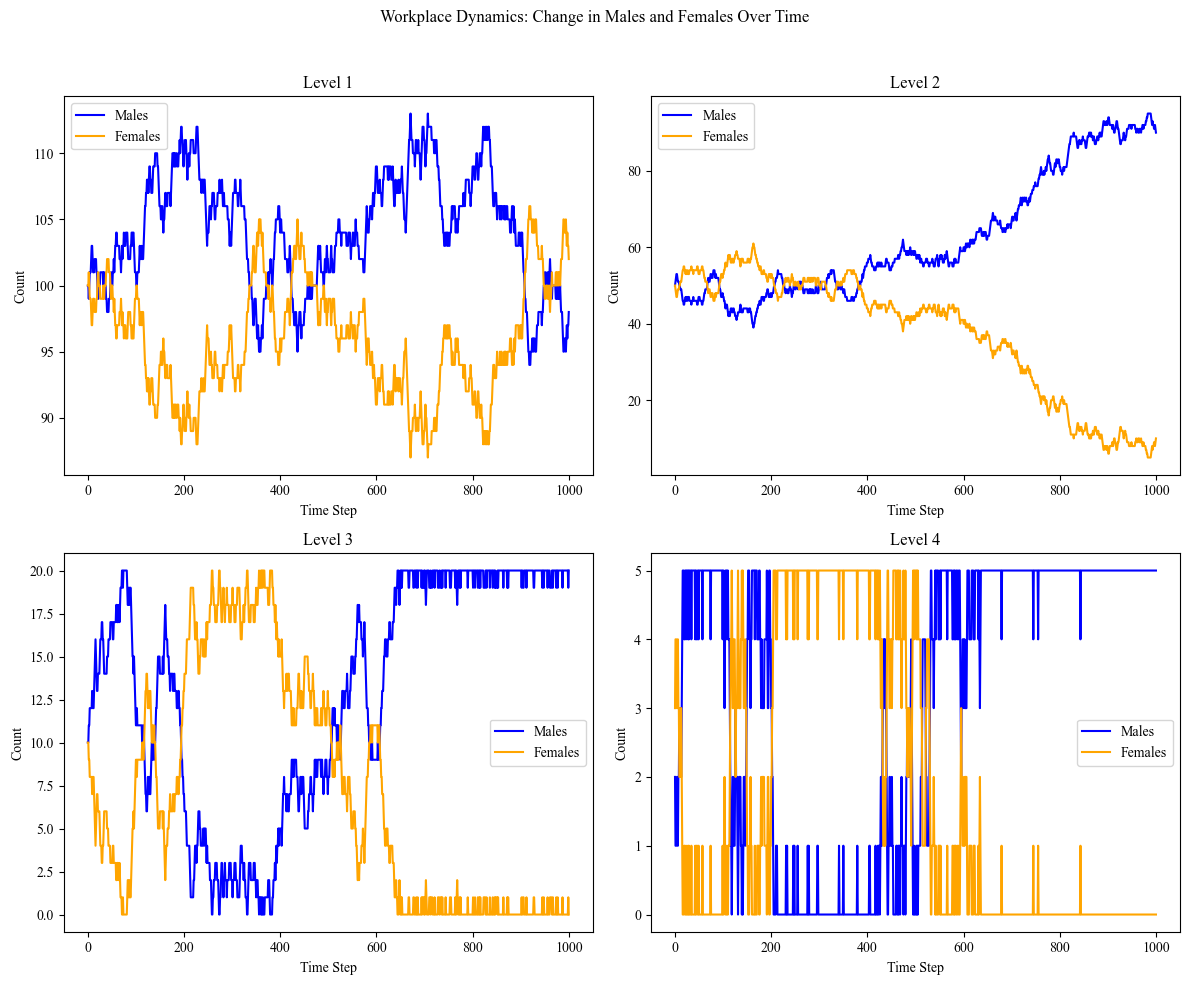

In [126]:
def plot_workplace_dynamics_line(data_list, level_sizes):
    """
    Plots the change in females and males over time for each level using a 2x2 subplot of line graphs.
    
    Args:
        data_list (list): 
            A list of tuples, where:
            - data_list[i][0] is the array with people leaving at each level at a given time step.
            - data_list[i][1] is a SimpleWorkplaceState object with the number of females.
    """
    n_levels = 4
    time_steps = len(data_list)
    females_over_time = []
    males_over_time = []
    
    for (time, state) in data_list:
        females_over_time.append(state.n_females)
        males_over_time.append(level_sizes - females_over_time[-1])
    
    females_over_time = np.array(females_over_time)
    males_over_time = np.array(males_over_time)
    
    # Create 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Workplace Dynamics: Change in Males and Females Over Time")
    
    for level in range(n_levels):
        row, col = divmod(level, 2)
        ax = axes[row, col]
        
        # Plot line graphs for males and females over time
        ax.plot(range(time_steps), males_over_time[:, level], label="Males", linestyle="-", color="blue")
        ax.plot(range(time_steps), females_over_time[:, level], label="Females", linestyle="-", color="orange")
        ax.set_title(f"Level {level + 1}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Count")
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

plot_workplace_dynamics_line(results, np.array(initial_workplace.n_levels))


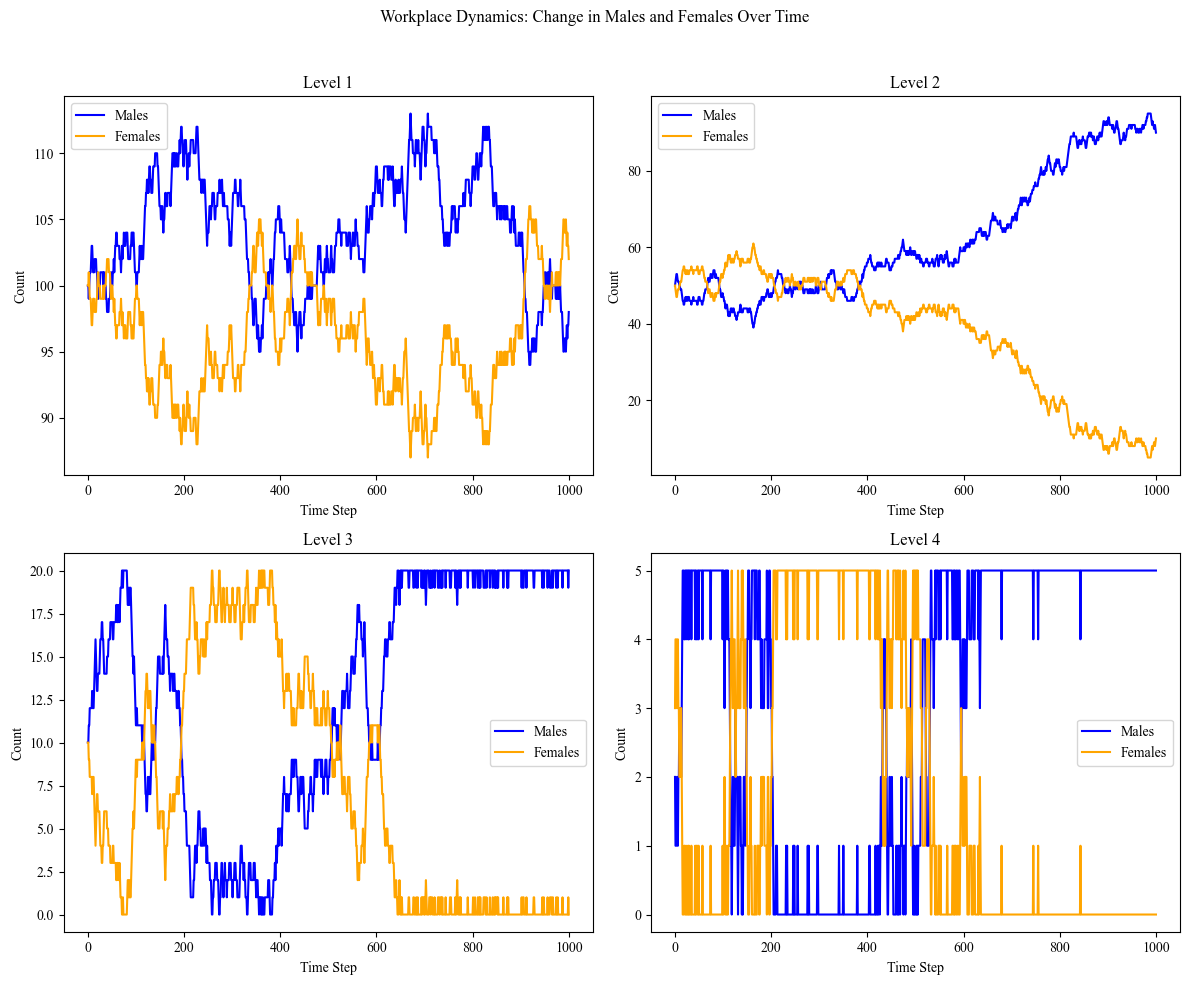

In [127]:
plot_workplace_dynamics_line(results, np.array(initial_workplace.n_levels))

## §3. More extensible model

### Extension 1: Affects of Seniority on Gender Bias

In [128]:
class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

@dataclass(frozen=True)
class Employee:
    identity: Identity
    hiring_and_promotion_times: Tuple[int, ...]

    @property
    def level(self) -> int:
        return len(self.hiring_and_promotion_times) - 1

    def time_at_current_level(self, t_now: int) -> int:
        return t_now - self.hiring_and_promotion_times[-1]

    @staticmethod
    def sample_new_hire(p_female: float, t_now: int) -> 'Employee':
        identity = Identity.FEMALE if RNG.random() < p_female else Identity.MALE
        return Employee(identity, (t_now,))

    def promoted(self, t_now: int) -> 'Employee':
        return Employee(
            self.identity,
            (*self.hiring_and_promotion_times, t_now),
        )

@dataclass
class ComplexWorkplaceState:
    employees_0: Tuple[Employee, ...]
    employees_1: Tuple[Employee, ...]
    employees_2: Tuple[Employee, ...]
    employees_3: Tuple[Employee, ...]
    t_now: int

    def to_simple_state(self) -> 'SimpleWorkplaceState':
        return SimpleWorkplaceState([
            sum(1 for e in level if e.identity == Identity.FEMALE)
            for level in [self.employees_0, self.employees_1, self.employees_2, self.employees_3]
        ])

@dataclass(frozen=True)
class WorkplaceParams:
    n_levels: List[int]
    departure_rate: np.ndarray  
    promotion_rate: np.ndarray 
    hiring_female_probability: float
    required_seniority: Tuple[int, ...]

@dataclass(frozen=True)
class SimpleWorkplaceState:
    n_females: List[int]

@dataclass
class ComplexWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: ComplexWorkplaceState) -> np.ndarray:
        return self.params.departure_rate + self.params.promotion_rate

    def sample_next(self, state: ComplexWorkplaceState) -> ComplexWorkplaceState:
        t_now = state.t_now + 1
        identity_indices = {Identity.MALE: 0, Identity.FEMALE: 1}
        employees_levels = [
            list(state.employees_0),
            list(state.employees_1),
            list(state.employees_2),
            list(state.employees_3)
        ]
        new_employees_levels = [[] for _ in range(len(employees_levels))]

        # Calculates the employees that will stay in the workplace
        for j, employees_j in enumerate(employees_levels):
            retained_employees = []
            for e in employees_j:
                i = identity_indices[e.identity]
                p_departure = self.params.departure_rate[i, j]
                if RNG.random() >= p_departure:
                    retained_employees.append(e)
            employees_levels[j] = retained_employees

        # Calculates the employees that will be promoted based on seniority
        for j in range(len(employees_levels) - 1):
            current_level_employees = employees_levels[j]
            next_level_employees = employees_levels[j + 1]
            max_promotions = self.params.n_levels[j + 1] - len(next_level_employees)
            eligible_employees = [
                e for e in current_level_employees
                if e.time_at_current_level(t_now) >= self.params.required_seniority[j]
            ]
            promotions = []
            for identity in [Identity.MALE, Identity.FEMALE]:
                i = identity_indices[identity]
                eligible_identity_employees = [e for e in eligible_employees if e.identity == identity]
                p_promotion = self.params.promotion_rate[i, j]
                promoted_employees = [
                    e for e in eligible_identity_employees if RNG.random() < p_promotion
                ]
                promotions.extend(promoted_employees)
            promotions = promotions[:max_promotions]
            employees_levels[j] = [e for e in current_level_employees if e not in promotions]

            # Adding promoted employees to next level
            promoted_employees = [e.promoted(t_now) for e in promotions]
            employees_levels[j + 1].extend(promoted_employees)

        vacancies = self.params.n_levels[0] - len(employees_levels[0])
        new_hires = [
            Employee.sample_new_hire(self.params.hiring_female_probability, t_now)
            for _ in range(vacancies) ]
        employees_levels[0].extend(new_hires)

        new_state = ComplexWorkplaceState(
            employees_0 = tuple(employees_levels[0]),
            employees_1 = tuple(employees_levels[1]),
            employees_2 = tuple(employees_levels[2]),
            employees_3 = tuple(employees_levels[3]),
            t_now = t_now
        )
        return new_state

In [129]:
def create_seniorty_workplace(required_seniority = (1, 2, 3, 4)):
    initial_levels = [200, 100, 20, 5]
    departure_rate = np.array([
        [0.05, 0.04, 0.03, 0.02], 
        [0.05, 0.04, 0.03, 0.02], 
    ])
    promotion_rate = np.array([
        [0.10, 0.08, 0.06, 0.00],  
        [0.10, 0.08, 0.06, 0.00],  
    ])

    hiring_female_probability = 0.5

    params = WorkplaceParams(
        n_levels=initial_levels,
        departure_rate=departure_rate,
        promotion_rate=promotion_rate,
        hiring_female_probability=hiring_female_probability,
        required_seniority=required_seniority
    )

    initial_employees = [
        tuple(Employee.sample_new_hire(0.5, 0) for _ in range(n))
        for n in initial_levels
    ]
    complex_initial_state = ComplexWorkplaceState(
        employees_0=initial_employees[0],
        employees_1=initial_employees[1],
        employees_2=initial_employees[2],
        employees_3=initial_employees[3],
        t_now=0
    )
    model = ComplexWorkplaceModel(params)
    return model, complex_initial_state

In [130]:
model, complex_initial_state = create_seniorty_workplace()

In [131]:
complex_results = run_ctmc(model, complex_initial_state, 1000)

#### Testing How Different Combinations of Seniority Affect Gender

In [132]:
def plot_complex_workplace_dynamics_line(data_list, level_sizes, required_seniority=(1, 2, 3, 4)):
      """
      Plots the change in females and males over time for each level using a 2x2 subplot of line graphs.
      
      Args:
            data_list (list): 
                  A list of tuples, where:
                  - data_list[i][0] is the time step.
                  - data_list[i][1] is a ComplexWorkplaceState object with the employees at each level.
      """
      n_levels = 4
      time_steps = len(data_list)
      females_over_time = []
      males_over_time = []
      
      for (time, state) in data_list:
            females_over_time.append([
                  sum(1 for e in state.employees_0 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_1 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_2 if e.identity == Identity.FEMALE),
                  sum(1 for e in state.employees_3 if e.identity == Identity.FEMALE),
            ])
            males_over_time.append([
                  sum(1 for e in state.employees_0 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_1 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_2 if e.identity == Identity.MALE),
                  sum(1 for e in state.employees_3 if e.identity == Identity.MALE),
            ])
      
      females_over_time = np.array(females_over_time)
      males_over_time = np.array(males_over_time)
      
      # Create 2x2 subplots
      fig, axes = plt.subplots(2, 2, figsize=(12, 10))
      fig.suptitle("Complex Workplace Dynamics: Change in Males and Females Over Time | Required Levels = " + str(required_seniority))
      
      for level in range(n_levels):
            row, col = divmod(level, 2)
            ax = axes[row, col]
            
            # Plot line graphs for males and females over time
            ax.plot(range(time_steps), males_over_time[:, level], label="Males", linestyle="-", color="blue")
            ax.plot(range(time_steps), females_over_time[:, level], label="Females", linestyle="-", color="orange")
            ax.set_title(f"Level {level + 1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Count")
            ax.legend()
      
      plt.tight_layout(rect=[0, 0, 1, 0.96]) 
      plt.show()

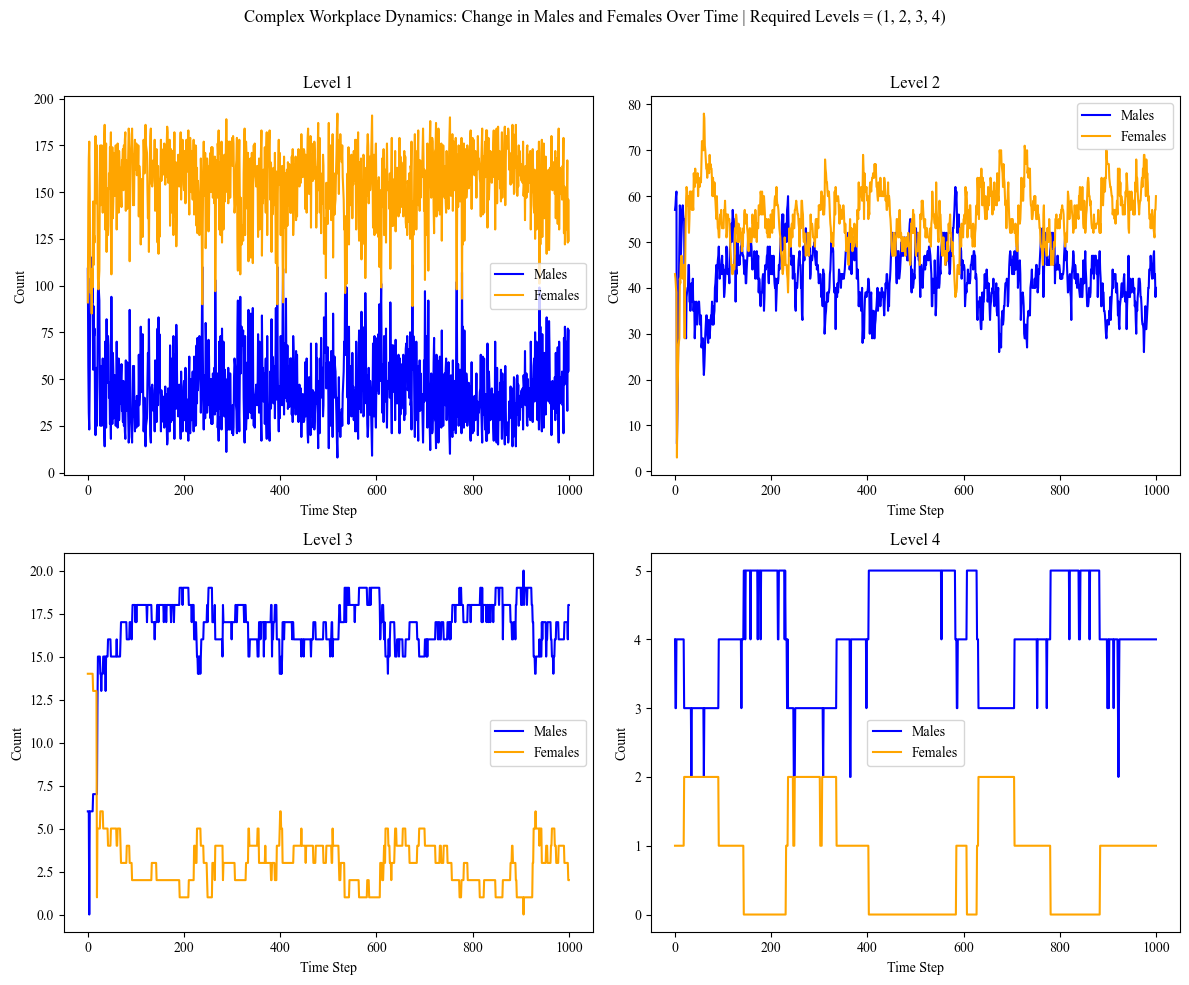

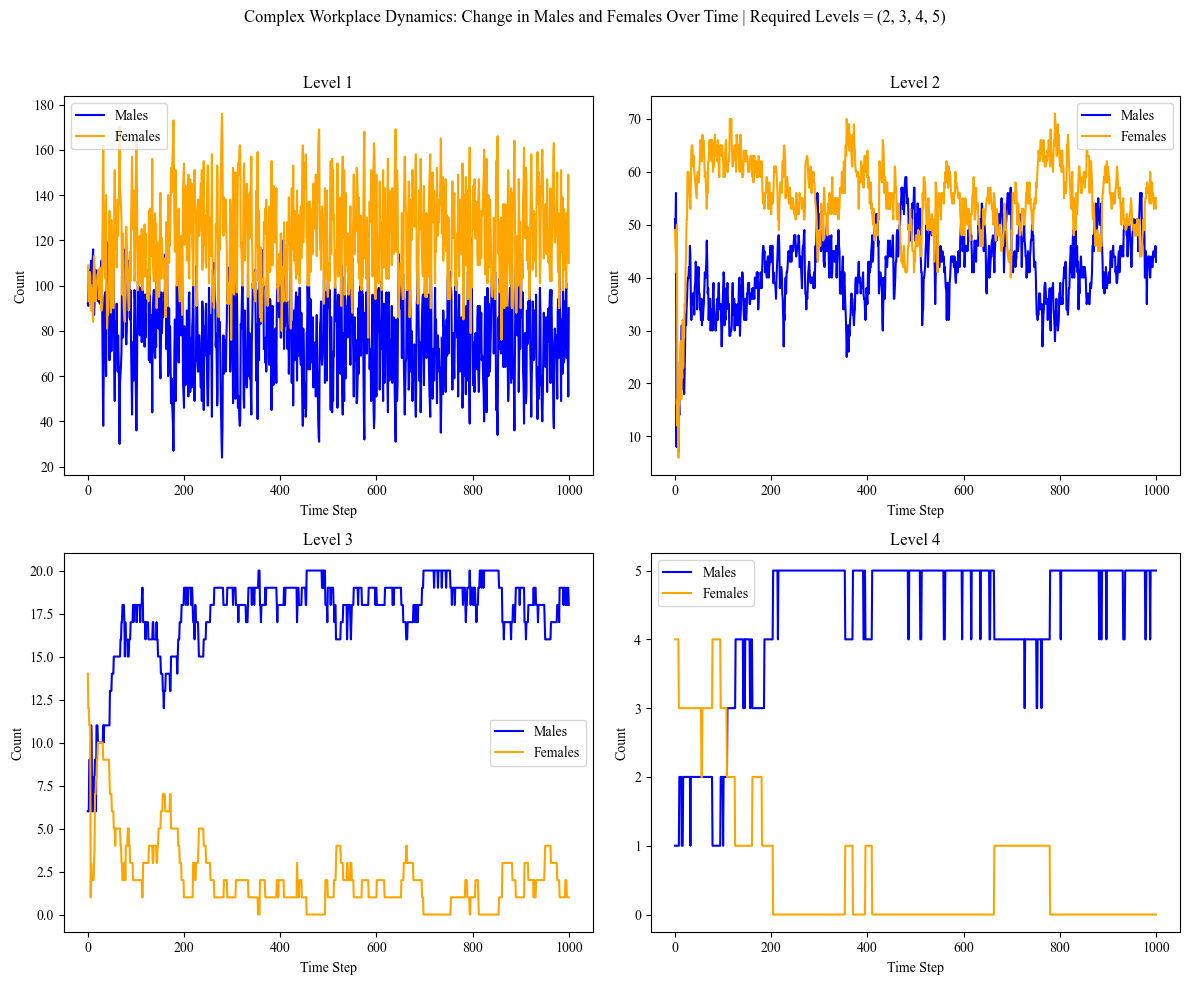

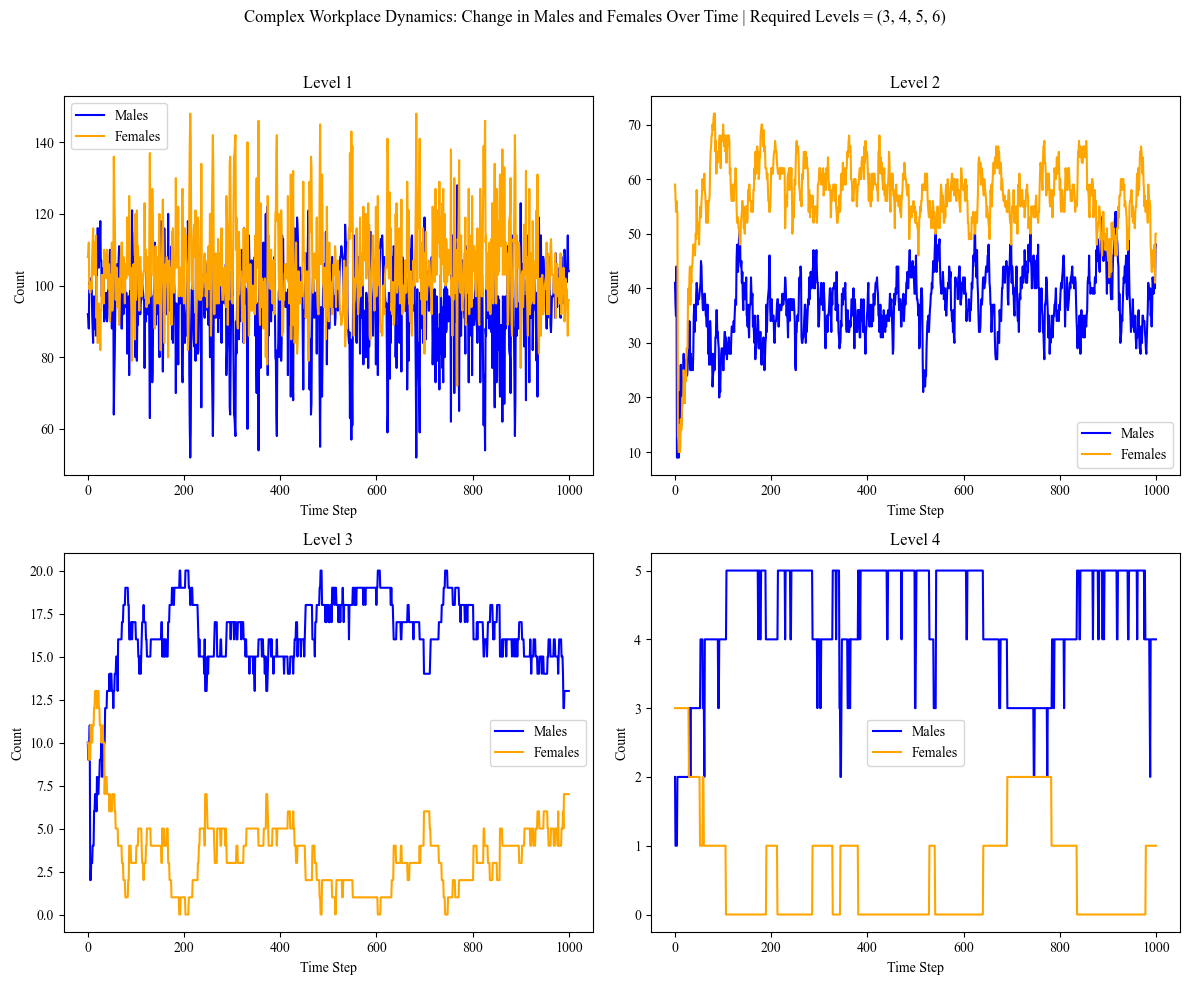

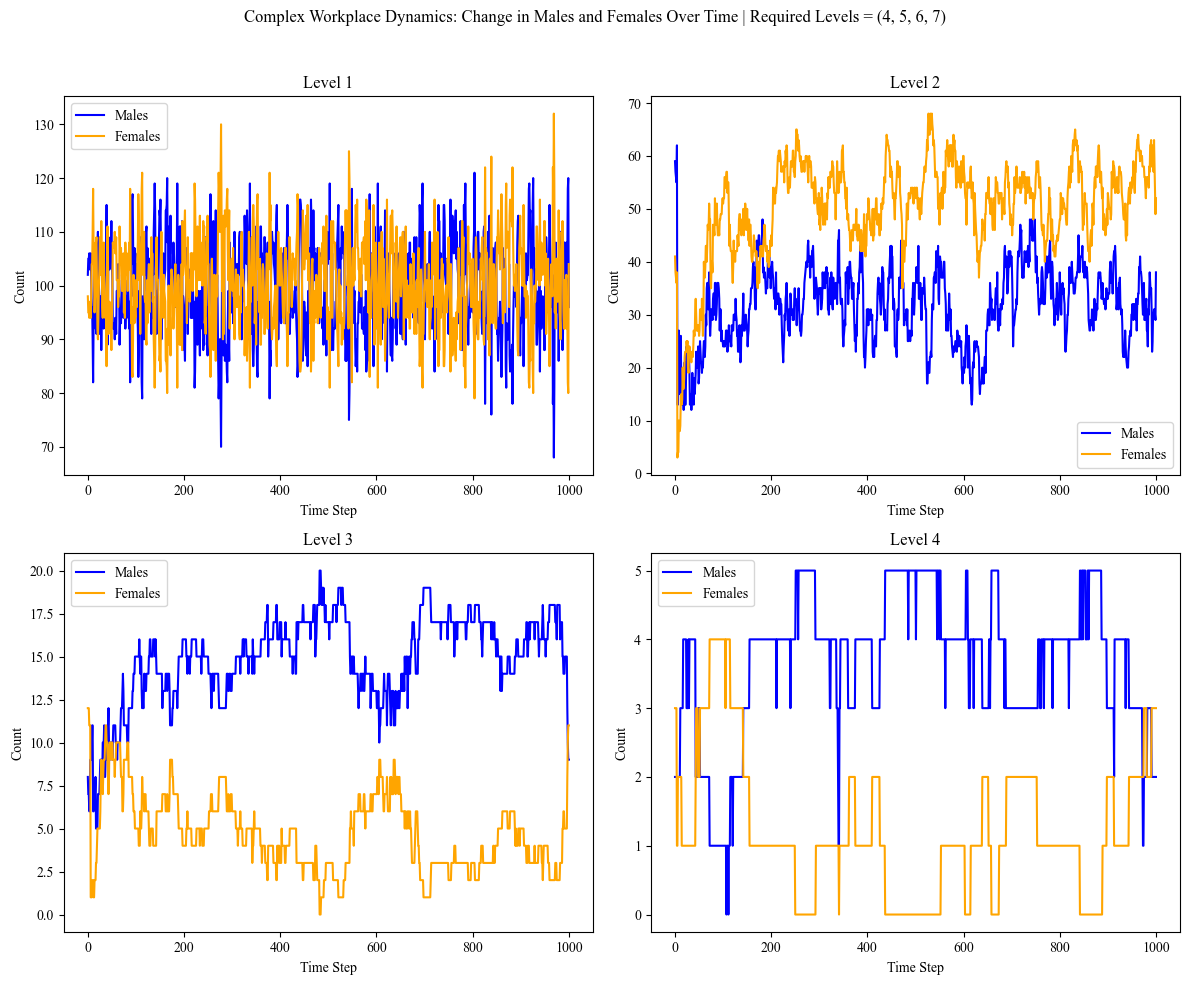

In [133]:
required_seniorities = [
      (1, 2, 3, 4),
      (2, 3, 4, 5),
      (3, 4, 5, 6),
      (4, 5, 6, 7),
]

for required_seniority in required_seniorities:
      model, complex_initial_state = create_seniorty_workplace(required_seniority)
      results = run_ctmc(model, complex_initial_state, 1000)
      plot_complex_workplace_dynamics_line(results, [1,2,3,4], required_seniority)

### Extension 2: Team Work Dynamics

In [142]:
@dataclass
class Employee:
    identity: Identity
    skill: float

    def improve_skill(self, increment = 0.01):
        self.skill += increment

@dataclass
class Team:
    employees: List[Employee]

    def avg_skill(self):
        if len(self.employees) == 0:
            return 0
        return np.mean([e.skill for e in self.employees])

    def diversity_score(self):
        """Simple diversity score based on ratio of males to females.
            Diversification Score = number of females x number of males / number of employees^2"""
        if len(self.employees) == 0:
            return 0
        
        num_female = sum(e.identity == Identity.FEMALE for e in self.employees)
        num_male = len(self.employees) - num_female
        return (num_female * num_male) / (len(self.employees)**2)

    def cohesion_score(self):
        # Define cohesion as variance of skill within the team
        return np.std([e.skill for e in self.employees])**2

    def performance(self, beta1 = 1.0, beta2 = 1.0):
        """Performance score based on average skill, diversity, and cohesion."""
        return self.avg_skill() * (beta1 * self.diversity_score() + beta2 * self.cohesion_score())

    def remove_employee(self, emp):
        self.employees.remove(emp)

    def add_employee(self, emp):
        self.employees.append(emp)

    def best_employee(self):
        # The "team lead" is defined to be the highest-skill employee for promotion
        return max(self.employees, key = lambda employee: employee.skill) if self.employees else None

class CompanyTree:
    """Represents a tree structure of teams"""
    def __init__(self, structure, p_departure=0.05):
        """
        structure: list of (n_teams, team_size)
                   Example: [(1,2), (2,4), (4,6)] means:
                     - Level 0: 1 team of size 2
                     - Level 1: 2 teams of size 4
                     - Level 2: 4 teams of size 6
        p_departure: probability of departure per employee per timestep
        """
        self.structure = structure
        self.levels = len(structure)
        self.teams = []
        self.p_departure = p_departure
        self.beta1 = 1.0
        self.beta2 = 1.0

        # Initialize teams with random employees
        for (n_teams, size) in structure:
            level_teams = []
            for _ in range(n_teams):
                # Random identities and skills
                employees = []
                for _ in range(size):
                    identity = RNG.choice([Identity.FEMALE, Identity.MALE])
                    skill = RNG.uniform(0,1)  # random skill [0,1]
                    employees.append(Employee(identity, skill))
                level_teams.append(Team(employees))
            self.teams.append(level_teams)

    def get_team(self, level, index):
        return self.teams[level][index]

    def step(self):
        """
        One discrete time step:
        1. Departures
        2. Promotions / hiring
        3. Skill improvement
        4. Compute performances
        """
        # 1. Departures
        vacancies = []  # (level, team_idx, count_of_vacancies)
        for level in reversed(range(self.levels)):
            for t_idx, team in enumerate(self.teams[level]):
                departing = []
                for emp in team.employees:
                    if np.random.rand() < self.p_departure:
                        departing.append(emp)
                for d_emp in departing:
                    team.remove_employee(d_emp)
                # Now we have vacancies: we must keep team size constant
                desired_size = self.structure[level][1]
                vac = desired_size - len(team.employees)
                if vac > 0:
                    vacancies.append((level, t_idx, vac))

        # romotions / hiring
        vacancies.sort(key=lambda x: x[0]) 
        for (level, t_idx, vac) in vacancies:
            if level == self.levels - 1:
                # Hiring externally if at bottom level (leaf)
                team = self.get_team(level, t_idx)
                for _ in range(vac):
                    self.hire_external(team)
            else:
                # Hire from lower levels for promotion
                promoted_count = 0
                while promoted_count < vac:
                    child_level = level + 1
                    # Always going to hire best person from best team below
                    candidate_teams = [tm for tm in self.teams[child_level] if tm.employees]
                    if not candidate_teams:
                        # If no candidates must hire externally 
                        team = self.get_team(level, t_idx)
                        self.hire_external(team)
                        promoted_count += 1
                        continue
                    best_team = max(candidate_teams, key=lambda x: x.performance(self.beta1, self.beta2))
                    leader = best_team.best_employee()
                    if leader is None:
                        # If no leader hire external
                        self.hire_external(self.get_team(level, t_idx))
                        promoted_count += 1
                    else:
                        best_team.remove_employee(leader)
                        self.get_team(level, t_idx).add_employee(leader)
                        promoted_count += 1

        # Employees gain skill as they continue to work longer
        for level_teams in self.teams:
            for team in level_teams:
                for emp in team.employees:
                    emp.improve_skill()

    def hire_external(self, team, diversity_prob = 1/3):
        # Probability:
        #  - diversity_prob from minority gender in the team to increase diversity
        #  - (1 - diversity_prob) from majority gender
        num_female = sum(e.identity == Identity.FEMALE for e in team.employees)
        num_male = len(team.employees) - num_female
        team_size = self.structure[self.find_team_level(team)][1]

        if num_female == num_male:
            identity = np.random.choice([Identity.FEMALE, Identity.MALE])
        else:
            diverse_group = Identity.FEMALE if num_female < num_male else Identity.MALE
            majority_group = Identity.MALE if diverse_group == Identity.FEMALE else Identity.FEMALE
            if RNG.uniform() < (diversity_prob):
                identity = diverse_group
            else:
                identity = majority_group

        skill = RNG.uniform(0,1)
        team.add_employee(Employee(identity, skill))

    def find_team_level(self, team):
        for i, level_teams in enumerate(self.teams):
            if team in level_teams:
                return i
        return None

    def get_female_proportion_by_level(self):
        proportions = []
        for i, level_teams in enumerate(self.teams):
            total = sum(len(t.employees) for t in level_teams)
            females = sum(e.identity == Identity.FEMALE for tm in level_teams for e in tm.employees)
            prop = females / total if total > 0 else 0
            proportions.append(prop)
        return proportions

    def get_average_skill_by_level(self):
        avg_skills = []
        for i, level_teams in enumerate(self.teams):
            all_emps = [e for t in level_teams for e in t.employees]
            if len(all_emps) == 0:
                avg_skills.append(0)
            else:
                avg_skills.append(np.mean([e.skill for e in all_emps]))
        return avg_skills


structure = [(1,2), (2,4), (4,6), (6, 12)]
company = CompanyTree(structure, p_departure = 0.1)

n_steps = 100
females_over_time = []
skills_over_time = []

for step in range(n_steps):
    females_over_time.append(company.get_female_proportion_by_level())
    skills_over_time.append(company.get_average_skill_by_level())
    company.step()

females_over_time = np.array(females_over_time)
skills_over_time = np.array(skills_over_time)

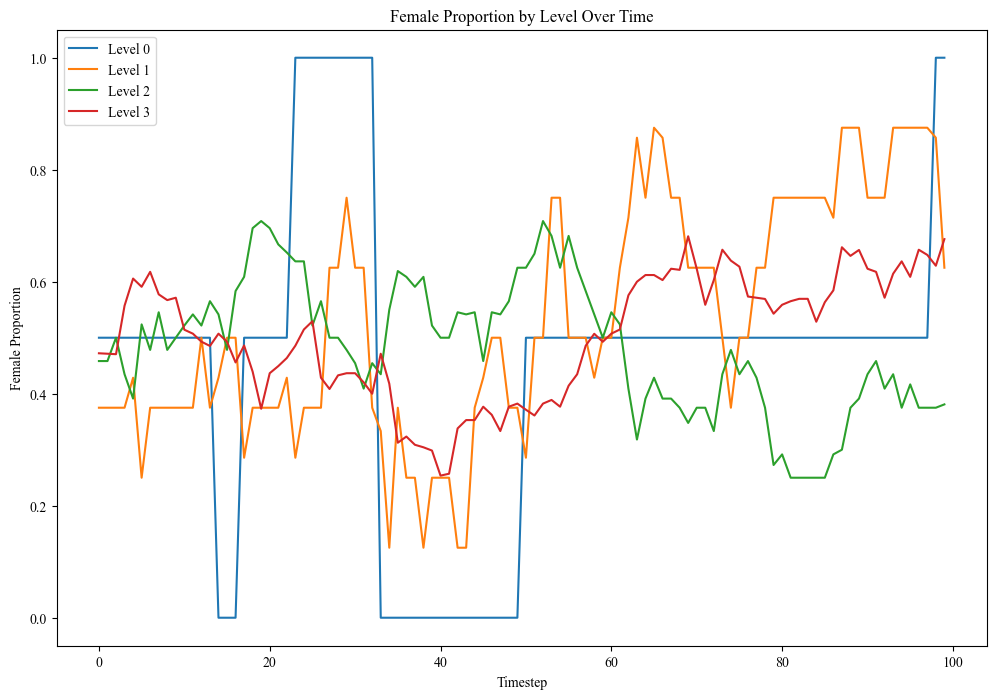

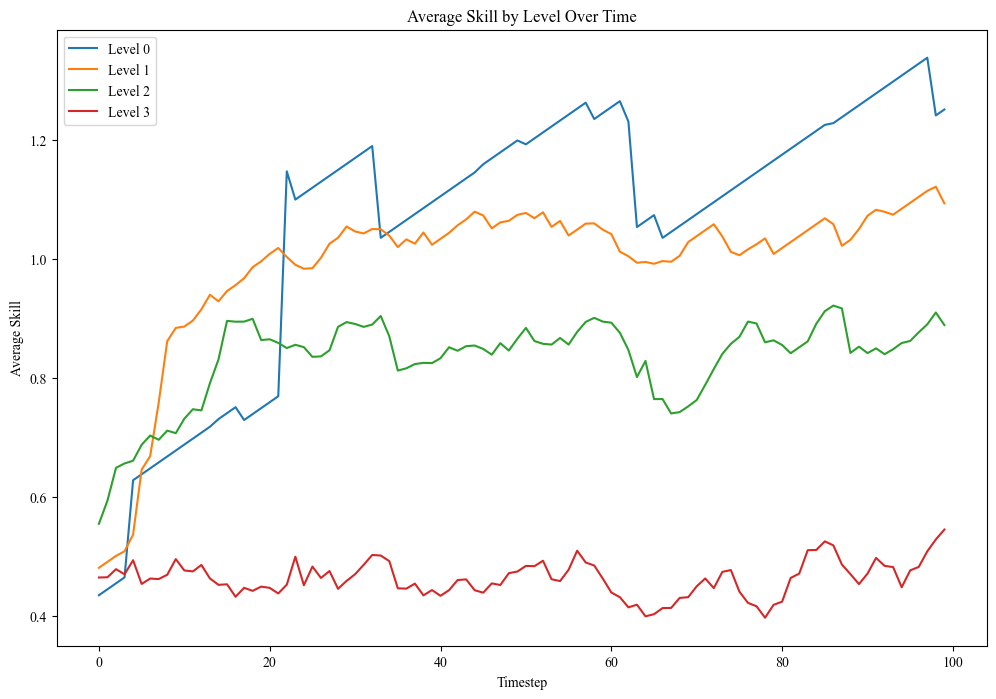

In [145]:
# Plot female proportion over time by level
for level in range(company.levels):
    plt.plot(females_over_time[:, level], label=f"Level {level}")
plt.title("Female Proportion by Level Over Time")
plt.xlabel("Timestep")
plt.ylabel("Female Proportion")
plt.legend()
plt.show()

for level in range(company.levels):
    plt.plot(skills_over_time[:, level], label=f"Level {level}")
plt.title("Average Skill by Level Over Time")
plt.xlabel("Timestep")
plt.ylabel("Average Skill")
plt.legend()
plt.show()

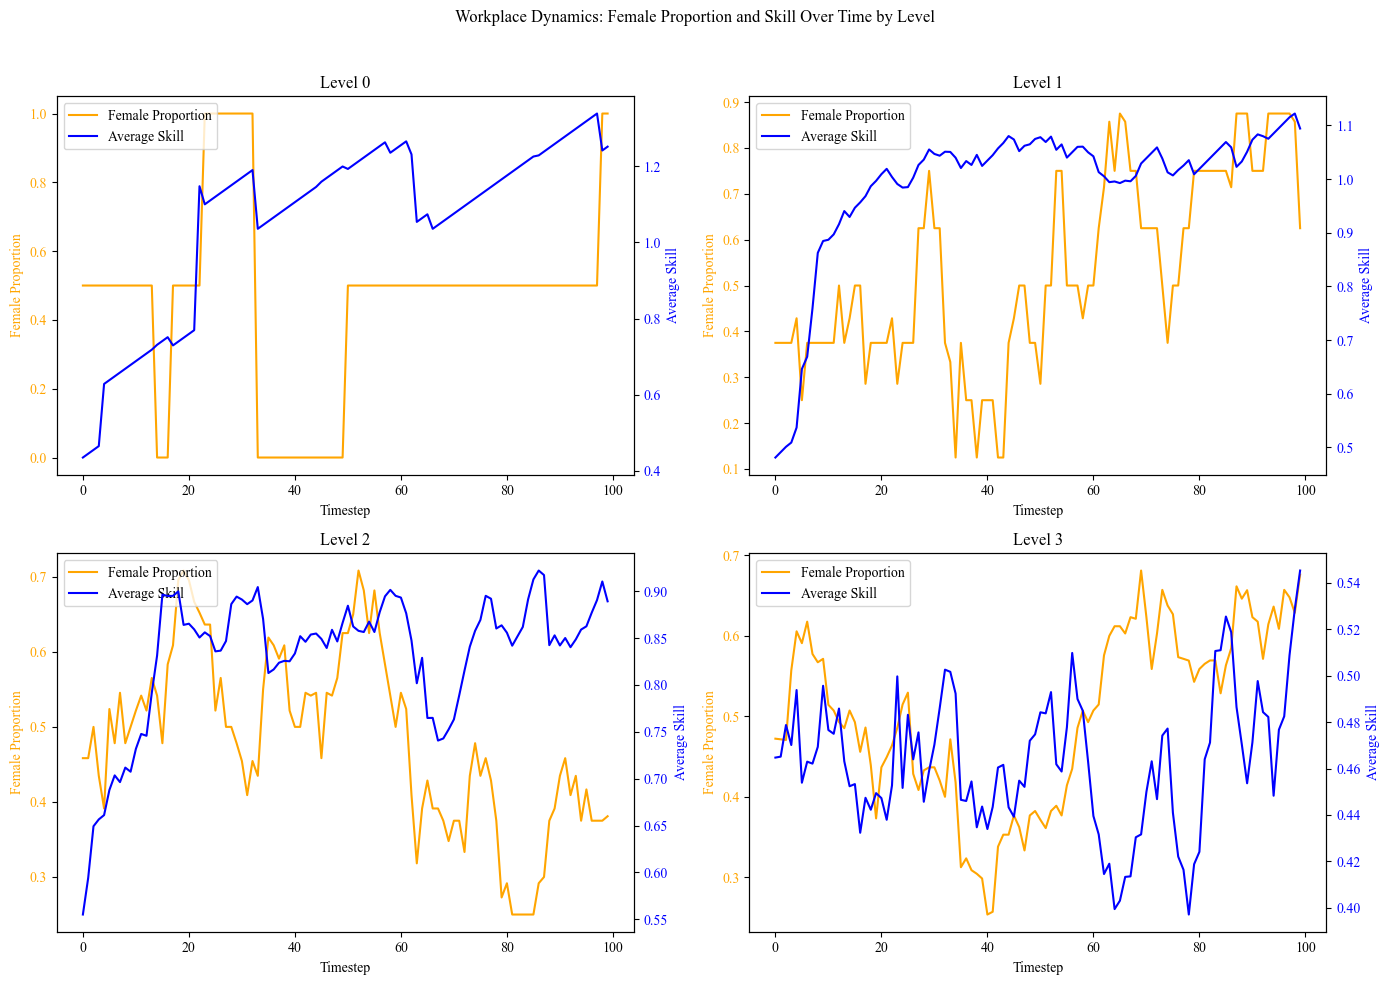

In [144]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Workplace Dynamics: Female Proportion and Skill Over Time by Level")

n_levels = company.levels
time_steps = np.arange(len(females_over_time))

for level in range(n_levels):
    row, col = divmod(level, 2)
    ax = axes[row, col]

    # Plot female proportion
    ax.plot(time_steps, females_over_time[:, level], color="orange", label="Female Proportion")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Female Proportion", color="orange")
    ax.tick_params(axis='y', labelcolor="orange")

    # Y-Axis for skill
    ax2 = ax.twinx()
    ax2.plot(time_steps, skills_over_time[:, level], color="blue", label="Average Skill")
    ax2.set_ylabel("Average Skill", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    ax.set_title(f"Level {level}")
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
